## GPT Implementation

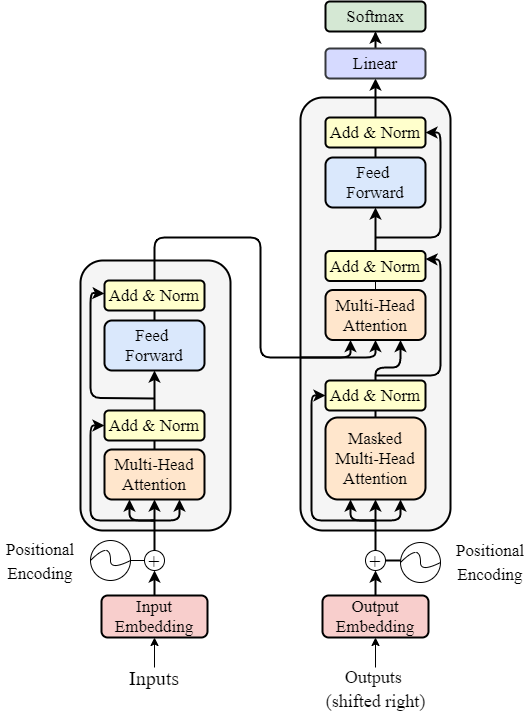

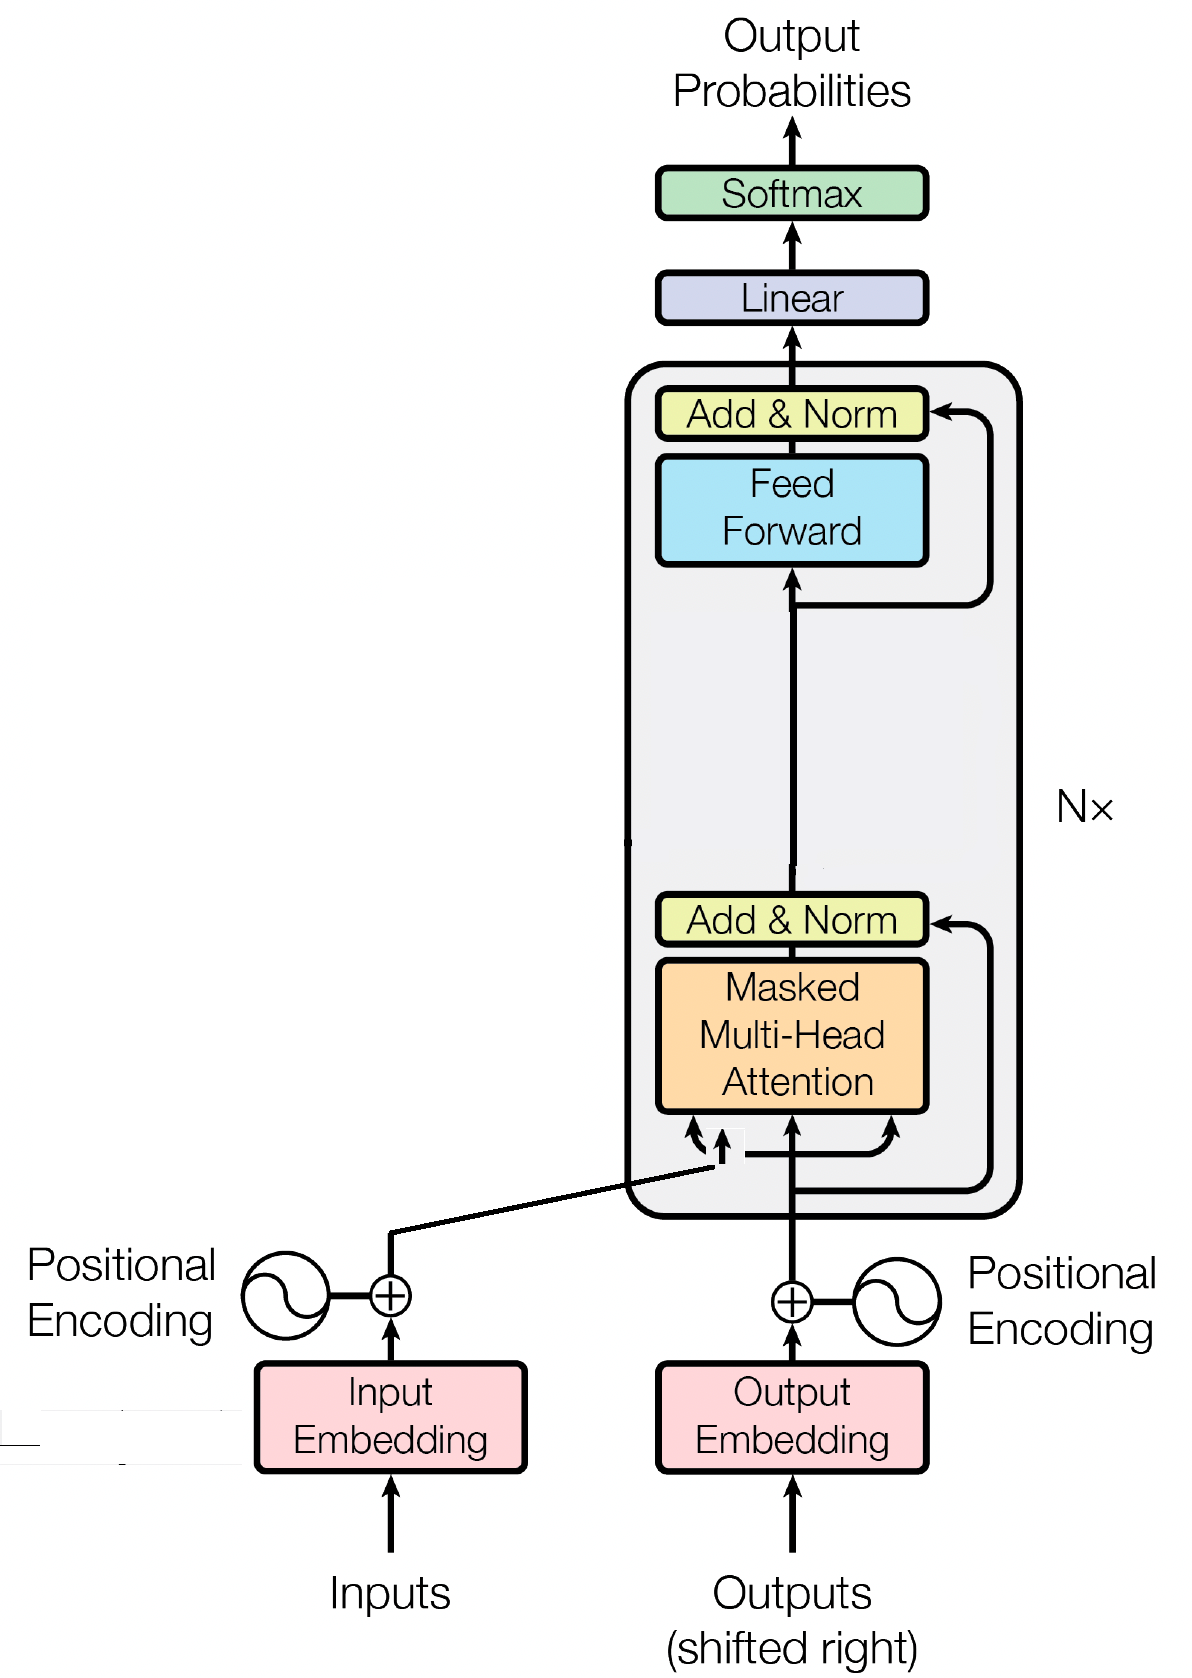

### Import modules and load checkpoint

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
from transformers import AutoConfig
import torch.nn.functional as F
from math import sqrt

model_ckpt = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
text = "Hello I'm a language model and,"


### Tokenization Example

In [10]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]])

### Load config and Embedding Example with config

In [11]:
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(50257, 768)

In [12]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()  ## batch size, seq_len, hidden_dim

torch.Size([1, 8, 768])

### Masked attention method

In [13]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

### Attention and MultiHead Attention

In [19]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        
        x = self.output_linear(hidden_state)
        return x

In [21]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 8, 768])

### Attention Visualization

In [22]:
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view

model2 = AutoModel.from_pretrained(model_ckpt, output_attentions=True)
viz_input = tokenizer(text, return_tensors='pt')
print(viz_input)
attention = model2(**viz_input).attentions
starting_point = (viz_input.input_ids == 15496).sum(dim=1)
tokens2 = tokenizer.convert_ids_to_tokens(viz_input.input_ids[0])

head_view(attention, tokens2, starting_point, heads=[8])


{'input_ids': tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


<IPython.core.display.Javascript object>

In [10]:
config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.39.3",
  "use_cache": true,
  "vocab_size": 50257
}

In [11]:
config.hidden_size * 4

3072

### FeedForward Module (In the other python script the equivalent is MLP)

In [23]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, 4 * config.hidden_size)
        self.linear_2 = nn.Linear(4 * config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.embd_pdrop)

    def forward(self, x):
        x = self.linear_1(x)
        print(x.shape)
        x = self.gelu(x)
        x = self.linear_2(x)
        print(x.shape)
        x = self.dropout(x)
        return x

In [24]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_output)
ff_outputs.size()

torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])


torch.Size([1, 8, 768])

In [14]:
# feed_forward.linear_1.weight.data = model.h[11].mlp.c_fc.weight.data
# feed_forward.linear_2.weight.data = model.h[11].mlp.c_proj.weight.data

### Transformer Decoder Module

In [25]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

### Token and positional Embeddingss

In [26]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                             config.hidden_size)
        self.position_embeddings = nn.Embedding(config.n_positions,
                                                config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.embd_pdrop)

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(-1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings) ## I added this!!!!
        return embeddings

In [27]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 8, 768])

### All Transformer Unit

In [28]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.lm_head(x)
        return logits

In [29]:
decoder = TransformerDecoder(config)
decoder(inputs.input_ids).size()

torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])


torch.Size([1, 8, 50257])

### Transformer Unit with Feed Forward Network for Text Generation

In [30]:
# class TransformerForTextGeneration(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.decoder = TransformerDecoder(config)
#         self.dropout = nn.Dropout(config.embd_pdrop)
#         self.ff_layer = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

#     def forward(self, x):
#         x = self.decoder(x)[:, -1, :]
#         x = self.dropout(x)
#         x = self.ff_layer(x)
#         x = F.softmax(x, dim=-1)
#         return x

In [32]:
# decoder_model = TransformerForTextGeneration(config)
# decoder_model_output = decoder_model(inputs.input_ids)

In [42]:
from transformers import GPT2Model

def load_pretrained_weights(model, pretrained_model_name='gpt2'):
    # Load the pre-trained GPT-2 model
    pretrained_model = GPT2Model.from_pretrained(pretrained_model_name)
    
    # Load the weights from the pre-trained model into the custom model
    model.embeddings.position_embeddings.weight = pretrained_model.wpe.weight
    model.embeddings.token_embeddings.weight = pretrained_model.wte.weight
    for i, layer in enumerate(model.layers):
        # Load attention weights
        for j, attn in enumerate(layer.attention.heads):
            attn.v.data = pretrained_model.h[i].attn.c_proj.weight.split(64, dim=0)[j].data
        
        # Load layer normalization weights
        layer.layer_norm_1.weight = pretrained_model.h[i].ln_1.weight
        layer.layer_norm_1.bias = pretrained_model.h[i].ln_1.bias
        layer.layer_norm_2.weight = pretrained_model.h[i].ln_2.weight
        layer.layer_norm_2.bias = pretrained_model.h[i].ln_2.bias
        
        # Load feed-forward weights
        layer.feed_forward.linear_1.weight = nn.Parameter(torch.transpose(pretrained_model.h[i].mlp.c_fc.weight, 0 ,1))
        layer.feed_forward.linear_1.bias = pretrained_model.h[i].mlp.c_fc.bias
        layer.feed_forward.linear_2.weight = nn.Parameter(torch.transpose(pretrained_model.h[i].mlp.c_proj.weight, 0, 1))
        layer.feed_forward.linear_2.bias = pretrained_model.h[i].mlp.c_proj.bias

In [43]:
load_pretrained_weights(decoder)

In [32]:
config.task_specific_params

{'text-generation': {'do_sample': True, 'max_length': 50}}

In [35]:
max_length = config.task_specific_params["text-generation"]["max_length"]
maximum_value = torch.argmax(decoder(inputs.input_ids))
maximum_value

torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])


tensor(373579)

In [36]:
inputs.input_ids.shape

torch.Size([1, 8])

In [37]:
input_ids = inputs.input_ids
input_ids

tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]])

### Generation Code

In [44]:
while input_ids.size(1) < max_length:
    ## forward the model to get the logits
    decoder.eval()
    with torch.no_grad():    
        probs = decoder(input_ids) ## (T, vocab_size)
        ## We'll do the top k sampling here (HF's default 50 for pipeline)
        # print(probs)
        probs = probs[:, -1, :]
        probs = F.softmax(probs, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 10, dim=-1, largest=True) ## If you want some fun change the 1 to some other number and you'll have different answers!!!
        ## Select a token from top-k probabilities
        # print(topk_indices)
        ix = torch.multinomial(topk_probs, 1, generator=torch.cuda.manual_seed(42), replacement=True) ## (B, 1)
        # print(ix)
        ## gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) ## (B, 1)
        xcol = torch.transpose(xcol, 0, 1)
        ## append to the sequence to get the full generated sentences
        input_ids = torch.cat((input_ids, xcol), dim=1)
        # print(input_ids)

# Print the predicted token IDs
# print(input_ids)

## decode and print the generated text
tokens = input_ids[0, :max_length].detach().to('cpu').tolist()
decoded = tokenizer.decode(tokens)
print(">", decoded)
input_ids = torch.tensor( [[15496,   314,  1101,   257,  3303,  2746,   290,    11]], dtype=torch.int)

torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 8, 3072])
torch.Size([1, 8, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 3072])
torch.Size([1, 9, 768])
torch.Size([1, 9, 30

##### In this work we didn't train any model. So there is no training or validation loop. This notebook is for illustration purposes and the aim is showing the model architecture and implementation details.

In [ ]:
model.state_dict()

In [ ]:
model

In [49]:
def generate_text(
    model, tokenizer, input_text, max_length=50, 
    do_sample=True, top_k=50, top_p=0.95, temperature=1.0
):
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids
    output_ids = input_ids

    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            logits = model(output_ids)
            print(f"benim süper logitlerim: #{logits}")
            next_token_logits = logits[:, -1]
            
            # Apply temperature scaling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            # Apply top-k and/or top-p sampling
            print(f"nex token: #{next_token_logits.shape}")
            next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            next_token_probs = F.softmax(next_token_logits, dim=-1)

            if do_sample:
                next_token = torch.multinomial(next_token_probs, 1)
            else:
                next_token = torch.argmax(next_token_probs, dim=-1, keepdim=True)


            
            output_ids = torch.cat([output_ids, torch.tensor([[next_token]])], dim=-1)
            print(f"output_ids: #{output_ids.shape} -- next_token: #{torch.tensor([[next_token]]).shape}")
            # Stop if EOS token is generated
            if next_token.item() == tokenizer.eos_token_id:
                break

    output_text = tokenizer.decode(output_ids[-1], skip_special_tokens=True)
    return output_text

def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
            Nucleus filtering (top-p) is described in Holtzman et al. (2019).
    """
    # Top-k filtering
    if top_k > 0:
        top_k = min(top_k, logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the top-k tokens
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    # Nucleus (top-p) filtering
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above top_p
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        print(f"unfiltered logits: #{logits.shape}")
        print(f"indices to remove: #{logits[0, indices_to_remove]}")
        print(f"indices to remove shape: #{logits[0, indices_to_remove].shape}")
        logits[0, indices_to_remove] = filter_value
        print(f"filtered logits: #{logits.shape}")

    return logits

In [50]:
from transformers import GPT2Model

def load_pretrained_weights2(model, pretrained_model_name='gpt2'):
    # Load the pre-trained GPT-2 model
    pretrained_model = GPT2Model.from_pretrained(pretrained_model_name)
    
    # Load the weights from the pre-trained model into the custom model
    model.embeddings.position_embeddings.weight = pretrained_model.wpe.weight
    model.embeddings.token_embeddings.weight = pretrained_model.wte.weight
    for i, layer in enumerate(model.layers):
        # Load attention weights
        for j, attn in enumerate(layer.attention.heads):
            attn.v.data = pretrained_model.h[i].attn.c_proj.weight.split(64, dim=0)[j].data
        
        # Load layer normalization weights
        layer.layer_norm_1.weight = pretrained_model.h[i].ln_1.weight
        layer.layer_norm_1.bias = pretrained_model.h[i].ln_1.bias
        layer.layer_norm_2.weight = pretrained_model.h[i].ln_2.weight
        layer.layer_norm_2.bias = pretrained_model.h[i].ln_2.bias
        
        # Load feed-forward weights
        layer.feed_forward.linear_1.weight = nn.Parameter(torch.transpose(pretrained_model.h[i].mlp.c_fc.weight, 0 ,1))
        layer.feed_forward.linear_1.bias = pretrained_model.h[i].mlp.c_fc.bias
        layer.feed_forward.linear_2.weight = nn.Parameter(torch.transpose(pretrained_model.h[i].mlp.c_proj.weight, 0, 1))
        layer.feed_forward.linear_2.bias = pretrained_model.h[i].mlp.c_proj.bias

In [51]:
def load_pretrained_weights3(custom_model, pretrained_model_name='gpt2'):
    pretrained_model = GPT2Model.from_pretrained(pretrained_model_name)
    custom_model.embeddings.token_embeddings.weight.data = pretrained_model.wte.weight.data
    custom_model.embeddings.position_embeddings.weight.data = pretrained_model.wpe.weight.data
    custom_model.embeddings.layer_norm.weight.data = pretrained_model.ln_f.weight.data
    custom_model.embeddings.layer_norm.bias.data = pretrained_model.ln_f.bias.data

    for i, layer in enumerate(custom_model.layers):
        pretrained_layer = pretrained_model.h[i]

        # Load attention weights
        qkv_weight = pretrained_layer.attn.c_attn.weight.data
        qkv_bias = pretrained_layer.attn.c_attn.bias.data

        hidden_size = pretrained_layer.attn.c_attn.weight.shape[0]
        split_size = hidden_size // 12

        query_weight = qkv_weight[:, :split_size]
        key_weight = qkv_weight[:, split_size:2 * split_size]
        value_weight = qkv_weight[:, 2 * split_size:]

        query_bias = qkv_bias[:split_size]
        key_bias = qkv_bias[split_size:2 * split_size]
        value_bias = qkv_bias[2 * split_size:]

        ## Assign the weights and biases to the custom model's attention layers
        for i, head in enumerate(layer.attention.heads):
            # print(f"query_weight: #{query_weight.shape}")
            # print(f"query_bias: #{query_bias.shape}")
            # print(f"key_weight: #{key_weight.shape}")
            # print(f"key_bias: #{key_bias.shape}")
            # print(f"value_weight: #{value_weight.shape}")
            # print(f"value_bias_: #{value_bias.shape}")
            head.q.weight.data = nn.Parameter(torch.transpose(query_weight, 0, 1))
            print(f"head head head: #{head.q.weight.data.shape}")
            head.q.bias.data = query_bias
            head.k.weight.data = nn.Parameter(torch.transpose(key_weight, 0, 1))
            head.k.bias.data = key_bias
            head.v.weight.data = nn.Parameter(torch.transpose(value_weight, 0, 1))
            head.v.bias.data = value_bias
        # layer.attention.output_linear.weight.data = pretrained_layer.attn.c_proj.weight.data
        # layer.attention.output_linear.bias.data = pretrained_layer.attn.c_proj.bias.data

        # Load layer normalization weights
        layer.layer_norm_1.weight = pretrained_model.h[i].ln_1.weight
        layer.layer_norm_1.bias = pretrained_model.h[i].ln_1.bias
        layer.layer_norm_2.weight = pretrained_model.h[i].ln_2.weight
        layer.layer_norm_2.bias = pretrained_model.h[i].ln_2.bias

        # Load feed-forward weights
        layer.feed_forward.linear_1.weight.data = nn.Parameter(torch.transpose(pretrained_layer.mlp.c_fc.weight.data, 0 , 1))
        layer.feed_forward.linear_1.bias.data = pretrained_layer.mlp.c_fc.bias.data
        layer.feed_forward.linear_2.weight.data = nn.Parameter(torch.transpose(pretrained_layer.mlp.c_proj.weight.data, 0 , 1))
        layer.feed_forward.linear_2.bias.data = pretrained_layer.mlp.c_proj.bias.data
        ## print(f"ulaaaaaanaannnnn: #{layer.attention.heads[11].v.weight.shape}")
    custom_model.lm_head.weight.data = pretrained_model.ln_f.weight.data


In [52]:
custom_model = TransformerDecoder(config)
for i, attn in enumerate(custom_model.layers):
    print(i, attn.attention.heads[0])

benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
0 AttentionHead(
  (q): Linear(in_features=768, out_features=64, bias=True)
  (k): Linear(in_features=768, out_features=64, bias=True)
  (v): Linear(in_features=768, out_features=64, bias=True)
)
1 AttentionHead(
  (q): Linear(in_features=768, out_features=64, bias=True)
  (k): Linear(in_features=768, out_features=64, bias=True)
  (v): Linear(in_features=768, out_features=64, bias=True)
)
2 AttentionHead(
  (q): Linear(in_features=768, out_features=64, bias=True)
  (k): Linear(in_features=768, out_features=64, bias=True)
  (v): Linear(in_features=768, out_features=64, bias=

In [53]:
from transformers import GPT2Config, GPT2Tokenizer, GPT2Model

config = GPT2Config()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
custom_model = TransformerDecoder(config)

# Load the custom lm_head weights into the model
load_pretrained_weights2(custom_model)

# Generate text
input_text = "Hello I'm a language model and"
output_text = generate_text(custom_model, tokenizer, input_text)
print(output_text)

/home/sercan/anaconda3/envs/pytorch-environment/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
benim head: #torch.Size([64, 768])
hidden_state: #torch.Size([1, 7, 768])
benim xim bilir işini: #torch.Size([1, 7, 768])
benim attentioun bilir işini: #torch.Size([1, 7, 768])
x: #torch.Size([1, 7, 768])
Sercannnn: #torch.Size([1, 7, 768])
torch.Size([1, 7, 3072])
torch.Size([1, 7, 768])
self feed forward: #torch.Size([1, 7, 768])
hidden_state: #torch.Size([1, 7, 768])
benim xim bilir işini: #torch.Size([1, 7, 768])
benim attentioun bilir işini: #torch.Size([1, 7, 768])
x: #torch.Size([1, 7, 768])
Sercannnn: #torch.Size([1, 7, 768])
torch.Size([1, 7, 3072])
torch.Size([1, 7, 768])
self feed forward: #torch.